#Breve explicación de la Notebook

Se utilizó la arquitectura InceptionV3 con Transfer Learning. Es decir,  incluyendo pesos pre - entrenados de ImageNet. Esto dió como resultado un considerablemente buen modelo, pero debido los resultados del F1 score comparados con otros modelos, se decidió no seguir indagando más en esta arquitectura. 

#Montaje e Importación de librerías

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
from tensorflow.keras.applications import InceptionV3
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
#from tensorflow.keras.layers.normalization import BatchNormalization
from keras.utils.vis_utils import plot_model
from keras.layers import Input, GlobalAveragePooling2D
from keras import models
from keras.models import Model, load_model
from keras.applications.inception_v3 import preprocess_input

In [10]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras import Sequential
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation,RandomFlip,Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import shutil
from tensorflow.keras.models import load_model, Model, Sequential
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from matplotlib import pyplot as plt
from keras import applications

In [11]:
!pip install -q --upgrade wandb
import wandb
from wandb.keras import WandbCallback
wandb.login()

     |████████████████████████████████| 1.6 MB 7.4 MB/s 
     |████████████████████████████████| 133 kB 59.2 MB/s 
     |████████████████████████████████| 170 kB 77.7 MB/s 
     |████████████████████████████████| 97 kB 9.2 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 


<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [13]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./03. Utils')
import importlib
#importlib.reload(MyFunctions)
import MyFunctions

#Modelo

##Inputs

In [14]:
IMAGE_SIZE = (128,128)
NUM_CLASSES = 3 
BATCH_SIZE = 32 

In [16]:
df_train=pd.read_excel("/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/train0-7.xlsx")
df_test=pd.read_excel("/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/test0-7.xlsx")

In [41]:
train_datagen = ImageDataGenerator(validation_split = 0.2,rescale = 1./255)#,,horizontal_flip=True,rotation_range=40)
dir = '/content/drive/My Drive/Quinto_Anio/TESIS_Eugenia_Berrino/DS_comp_nodef'
train_batches = train_datagen.flow_from_dataframe( #tomamos info de un df
    df_train, 
    directory=dir,
    x_col='ImageID',y_col='Projection',
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=BATCH_SIZE,
    subset = "training",
    seed=42,
    class_mode="categorical",)

Found 13951 validated image filenames belonging to 3 classes.


In [42]:
valid_batches = train_datagen.flow_from_dataframe(df_train, directory=dir,
                                            x_col='ImageID',y_col='Projection',
                                            target_size=IMAGE_SIZE,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            subset = "validation",
                                            seed=42,
                                            class_mode="categorical",)

Found 3487 validated image filenames belonging to 3 classes.


##Model Definition & Training

In [43]:
base_model = InceptionV3(weights= 'imagenet', 
                                include_top=False, 
                                input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
base_model.trainable = False
add_model = Sequential()
add_model.add(base_model)
add_model.add(Flatten()) 
add_model.add(Dense(256, activation="relu"))  
add_model.add(Dense(NUM_CLASSES, activation='softmax'))

model = add_model
adam = Adam(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2, 2, 2048)        21802784  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 771       
Total params: 23,900,963
Trainable params: 2,098,179
Non-trainable params: 21,802,784
_________________________________________________________________


In [44]:
# Initialize wandb with your project name
run = wandb.init(project='filter',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.0001,
                     "epochs": 100,
                     "batch_size": 32,
                     "loss_function": "categorical_crossentropy",
                     "architecture": "Inception V3",
                     "dataset": "PA-AP-L"
                 })
config = wandb.config

epoch,33
loss,0.12772
accuracy,0.98344
val_loss,0.26593
val_accuracy,0.97849
_runtime,4185
_timestamp,1629560669
_step,33
best_val_loss,0.20335
best_epoch,23


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
loss,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▄▅▄▅▅▆▆▆▆▆▆▇▇▇▆▆▇▇▇▇▇▆▇██▇▇▇████▇
val_loss,▅█▅▃▃▄▂▂▄▂▂▂▂▃▂▁▂▁▂▁▁▁▂▁▁▁▂▂▁▁▂▁▂▁
val_accuracy,▆▁▅▇▆▆█▇▃█▅▅▇▄▆▇▇▇▄█▆█▆██▇▅▃█▇▇▇▇█
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███


In [45]:
history = model.fit(train_batches, validation_data = valid_batches , epochs = 100,workers=10, 
                    callbacks=[EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True),WandbCallback()],
                    batch_size = BATCH_SIZE)

Epoch 1/100
436/436 [==============================] - 117s 258ms/step - loss: 0.1428 - accuracy: 0.9679 - val_loss: 0.0633 - val_accuracy: 0.9822
Epoch 2/100
436/436 [==============================] - 111s 251ms/step - loss: 0.0568 - accuracy: 0.9863 - val_loss: 0.0585 - val_accuracy: 0.9848
Epoch 3/100
436/436 [==============================] - 109s 247ms/step - loss: 0.0428 - accuracy: 0.9889 - val_loss: 0.0627 - val_accuracy: 0.9816
Epoch 4/100
436/436 [==============================] - 108s 246ms/step - loss: 0.0272 - accuracy: 0.9933 - val_loss: 0.0572 - val_accuracy: 0.9839
Epoch 5/100
436/436 [==============================] - 107s 242ms/step - loss: 0.0223 - accuracy: 0.9939 - val_loss: 0.0641 - val_accuracy: 0.9837
Epoch 6/100
436/436 [==============================] - 108s 244ms/step - loss: 0.0223 - accuracy: 0.9933 - val_loss: 0.0587 - val_accuracy: 0.9859
Epoch 7/100
436/436 [==============================] - 105s 239ms/step - loss: 0.0134 - accuracy: 0.9961 - val_loss: 0

In [46]:
model.save('/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./04. Weights/Exp 2: Mejoras a la Clasificaciónde proyecciones/Inception_TL.h5')

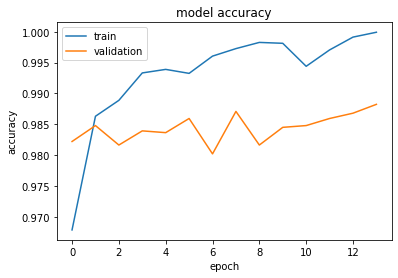

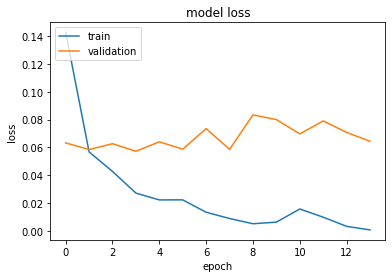

In [47]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

##Test

In [48]:
dir = '/content/drive/My Drive/Quinto_Anio/TESIS_Eugenia_Berrino/DS_comp_nodef'
test_datagen = ImageDataGenerator(rescale = 1./255) 
test_batches = test_datagen.flow_from_dataframe(
    df_test, 
    directory=dir,
    x_col='ImageID',y_col='Projection',
    target_size=IMAGE_SIZE,
    shuffle=False,
    batch_size=1,
    seed=42,
    class_mode="categorical"
    )

Found 4360 validated image filenames belonging to 3 classes.


In [36]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./04. Weights/Exp 2: Mejoras a la Clasificaciónde proyecciones/Inception_TL.h5')

In [49]:
#Calculamos la matriz de predicciones
result_test=model.predict(test_batches, verbose=1)
print(result_test.shape)

4360/4360 [==============================] - 74s 17ms/step
(4360, 3)


In [50]:
pd.DataFrame(result_test).to_csv('/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./01. Filtrado/03. Exp 2: Mejoras a la Clasificación de Proyecciones/03. InceptionV3/Results/result_inception_TL.csv')

In [51]:
#Obtenemos el nombre de clase asociado a cada indice
classes_dict = dict(zip(train_batches.class_indices.values(),train_batches.class_indices.keys()))
classes_dict

{0: 'AP_horizontal', 1: 'L', 2: 'PA'}

In [52]:
preds_classes, gts = MyFunctions.after_test(classes_dict,result_test,test_batches)

PA               2705
L                1449
AP_horizontal     206
dtype: int64
               precision    recall  f1-score   support

AP_horizontal       0.94      0.89      0.91       217
            L       0.98      1.00      0.99      1427
           PA       0.99      0.99      0.99      2716

     accuracy                           0.99      4360
    macro avg       0.97      0.96      0.96      4360
 weighted avg       0.99      0.99      0.99      4360



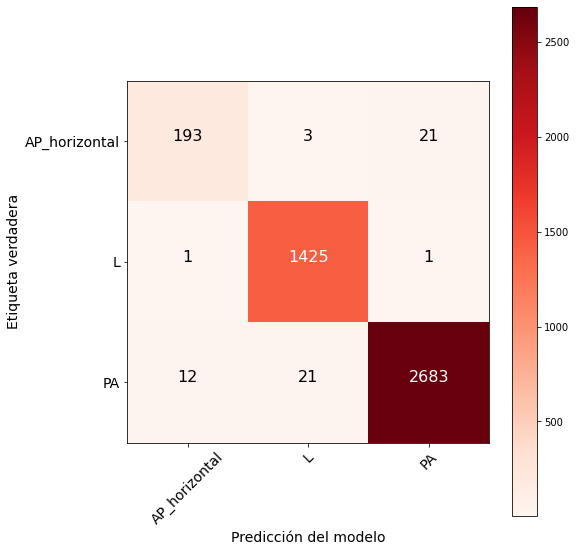

In [53]:
MyFunctions.plot_confusion_matrix(gts,preds_classes,test_batches.class_indices.keys(),
                                  path='/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./01. Filtrado/03. Exp 2: Mejoras a la Clasificación de Proyecciones/03. InceptionV3/Images/CM_Inception_TL')

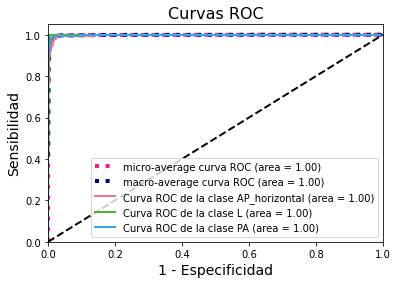

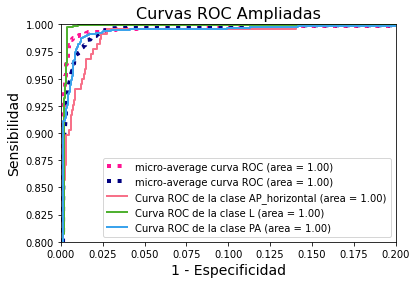

In [54]:
MyFunctions.plot_ROC(result_test,gts,NUM_CLASSES, classes_dict,
                     path='/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./01. Filtrado/03. Exp 2: Mejoras a la Clasificación de Proyecciones/03. InceptionV3/Images/ROC_Inception_TL')

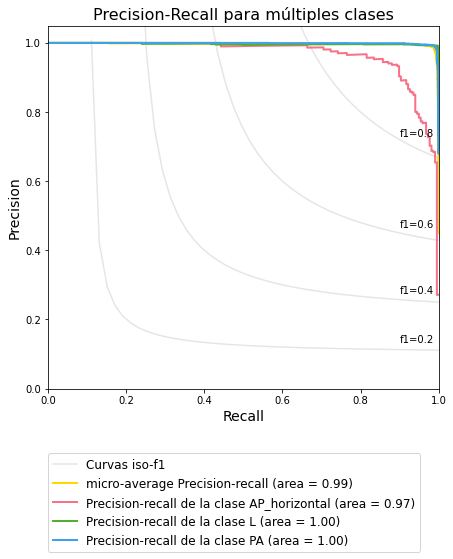

In [55]:
MyFunctions.precision_recall_many(result_test,gts,NUM_CLASSES, classes_dict,
                                  path='/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./01. Filtrado/03. Exp 2: Mejoras a la Clasificación de Proyecciones/03. InceptionV3/Images/PRM_Inception_TL')

In [56]:
df_test["Pred"] = preds_classes

In [59]:
df_test.head()

,Unnamed: 0,ImageID,ImageDir,Projection,Pred
0,0,5/117461681536540587607592076584888612953_wmoy...,5,PA,PA
1,1,0/214260817085057432303623958907855926368_jrl2...,0,PA,PA
2,2,4/144306045728819370188471558682816175107_vhmd...,4,PA,PA
3,3,1/213096160366986458367121958911602047465_wble...,1,PA,PA
4,4,4/280022667207150747197673782766436308679_15wi...,4,PA,PA


In [60]:
df_test = df_test.drop(columns=['Unnamed: 0'])

In [61]:
df_test["result"] = df_test["Projection"]==df_test["Pred"]
df_test.head()

,ImageID,ImageDir,Projection,Pred,result
0,5/117461681536540587607592076584888612953_wmoy...,5,PA,PA,True
1,0/214260817085057432303623958907855926368_jrl2...,0,PA,PA,True
2,4/144306045728819370188471558682816175107_vhmd...,4,PA,PA,True
3,1/213096160366986458367121958911602047465_wble...,1,PA,PA,True
4,4/280022667207150747197673782766436308679_15wi...,4,PA,PA,True


In [62]:
df_test.to_csv('/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./01. Filtrado/03. Exp 2: Mejoras a la Clasificación de Proyecciones/03. InceptionV3/Results/final_result_inception_TL.csv')